In [363]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
# 分割数据
from sklearn.model_selection import train_test_split
#回归问题
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from template import plot_learning_curve

In [364]:

train_data = pd.read_csv('data/car_price_prediction/train_1.csv',sep=' ')
test_data = pd.read_csv('data/car_price_prediction/test_1.csv',sep=' ')
# 一列数据需要处理成多列
train_data.head()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,...,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,...,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,...,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,...,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,...,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482


In [365]:
train_data.shape

(120000, 31)

In [366]:
test_data.shape

(30000, 31)

In [367]:
# 方便特征构造
data = pd.concat([train_data, test_data], axis=0)

In [368]:
numeric_features = ['power', 'kilometer', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13','v_14' ]

categorical_features = ['name', 'model', 'brand', 'bodyType', 'fuelType', 'gearbox', 'notRepairedDamage', 'regionCode',]

In [369]:
# 特征nunique分布
for cat_fea in categorical_features:
    print(cat_fea + "的特征分布如下:")
    print("{}特征有个{}不同的值".format(cat_fea, train_data[cat_fea].nunique()))
    print(train_data[cat_fea].value_counts())

name的特征分布如下:
name特征有个81760不同的值
387       233
708       222
55        221
1541      213
203       183
         ... 
160743      1
134120      1
7146        1
136921      1
100497      1
Name: name, Length: 81760, dtype: int64
model的特征分布如下:
model特征有个247不同的值
0.0      9445
19.0     7616
4.0      6780
1.0      4819
29.0     4120
         ... 
242.0       2
244.0       2
209.0       2
245.0       2
240.0       2
Name: model, Length: 247, dtype: int64
brand的特征分布如下:
brand特征有个40不同的值
0     25189
4     13428
14    12865
10    11374
1     11071
6      8151
9      5871
5      3732
13     3010
11     2366
3      1933
7      1876
16     1805
8      1657
27     1654
25     1652
21     1243
15     1171
19     1093
20     1020
12      903
22      891
26      754
30      742
17      727
24      596
28      518
32      463
29      326
37      269
2       251
18      248
31      242
36      192
34      187
33      166
23      158
35      148
38       50
39        8
Name: brand, dtype: int64
bodyType的特征分布如下

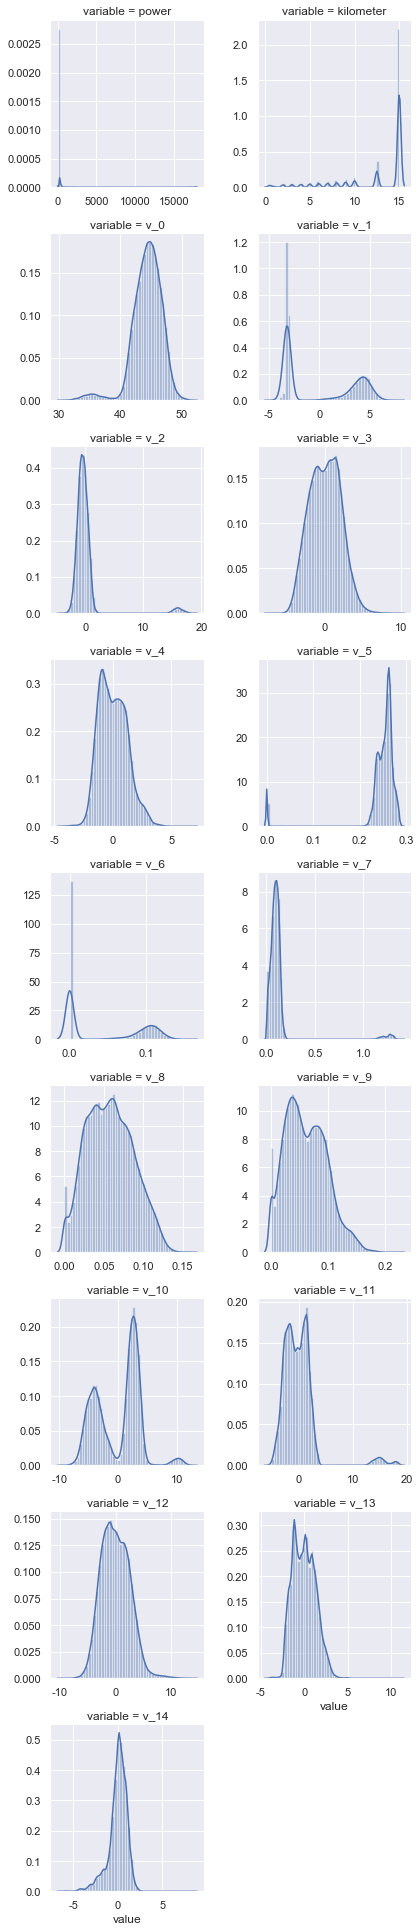

In [370]:
f = pd.melt(train_data, value_vars=numeric_features)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


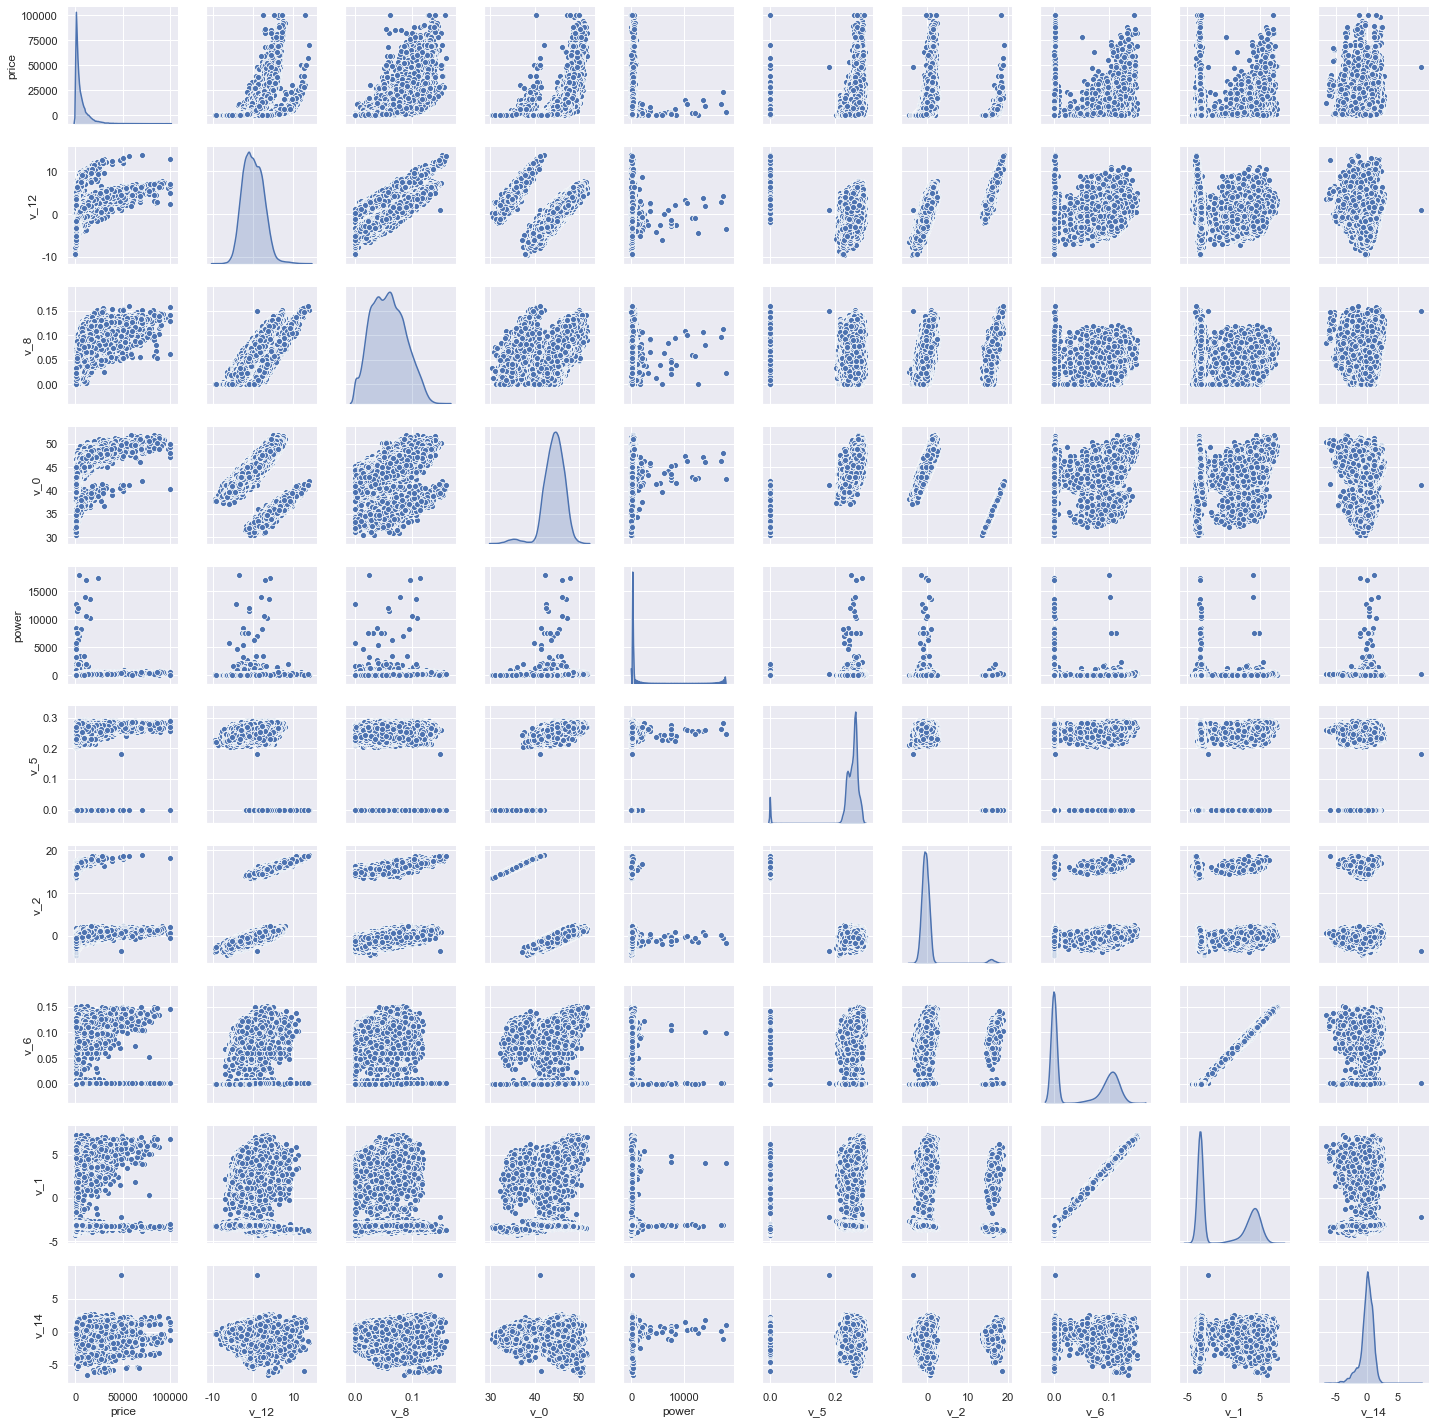

In [317]:
sns.set()
columns = ['price', 'v_12', 'v_8' , 'v_0', 'power', 'v_5',  'v_2', 'v_6', 'v_1', 'v_14']
sns.pairplot(train_data[columns],size = 2 ,kind ='scatter',diag_kind='kde')
plt.show()

In [371]:
numeric_features.append('price')
price_numeric = train_data[numeric_features]
correlation = price_numeric.corr()
print(correlation['price'].sort_values(ascending = False),'\n')

price        1.000000
v_12         0.693539
v_8          0.686825
v_0          0.629305
power        0.237272
v_5          0.165412
v_2          0.084937
v_6          0.066862
v_1          0.058770
v_14         0.035254
v_13        -0.014580
v_7         -0.053505
v_4         -0.147638
v_9         -0.207113
v_10        -0.244990
v_11        -0.277497
kilometer   -0.442213
v_3         -0.731521
Name: price, dtype: float64 



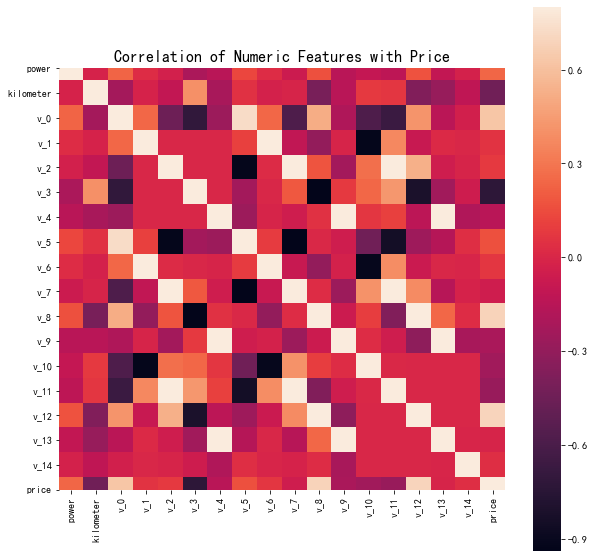

In [282]:
f , ax = plt.subplots(figsize = (10, 10))

plt.title('Correlation of Numeric Features with Price',y=1,size=16)

sns.heatmap(correlation,square = True,  vmax=0.8)

In [372]:
data.isnull().sum()

SaleID                  0
name                    0
regDate                 0
model                   1
brand                   0
bodyType             4506
fuelType             8680
gearbox              5981
power                   0
kilometer               0
notRepairedDamage       0
regionCode              0
seller                  0
offerType               0
creatDate               0
price                   0
v_0                     0
v_1                     0
v_2                     0
v_3                     0
v_4                     0
v_5                     0
v_6                     0
v_7                     0
v_8                     0
v_9                     0
v_10                    0
v_11                    0
v_12                    0
v_13                    0
v_14                    0
dtype: int64

In [373]:
def precess(data):
    #处理空值
    data['model'] = data['model'].fillna(data['model'].median())
    data['bodyType'] = data['bodyType'].fillna(data['bodyType'].median())
    data['fuelType'] = data['fuelType'].fillna(data['fuelType'].median())
    data['gearbox'] = data['gearbox'].fillna(data['gearbox'].median())

    print((data['notRepairedDamage']=='-').sum())
    index = data['notRepairedDamage']=='-'
    data['notRepairedDamage'][index] = '-1' #-1表示为上报

    # 使用时间：data['creatDate'] - data['regDate']，反应汽车使用时间，一般来说价格与使用时间成反比
    # 不过要注意，数据里有时间出错的格式，所以我们需要 errors='coerce'
    data['used_time'] = (pd.to_datetime(data['creatDate'], format='%Y%m%d', errors='coerce') - 
                                pd.to_datetime(data['regDate'], format='%Y%m%d', errors='coerce')).dt.days

    data['city'] = data['regionCode'].apply(lambda x : str(x)[:-3])
    data = data.drop(['SaleID','name','creatDate', 'regDate', 'regionCode'], axis=1)

    return data
data = precess(data)

24324


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [374]:
data['used_time'] = data['used_time'].fillna(data['used_time'].mean())

In [375]:
# 这里要以 train 的数据计算统计量
Train_gb = data.groupby("brand")
all_info = {}
for kind, kind_data in Train_gb:
    info = {}
    kind_data = kind_data[kind_data['price'] > 0]
    info['brand_amount'] = len(kind_data)
    info['brand_price_max'] = kind_data.price.max()
    info['brand_price_median'] = kind_data.price.median()
    info['brand_price_min'] = kind_data.price.min()
    info['brand_price_sum'] = kind_data.price.sum()
    info['brand_price_std'] = kind_data.price.std()
    info['brand_price_average'] = round(kind_data.price.sum() / (len(kind_data) + 1), 2)
    all_info[kind] = info
brand_fe = pd.DataFrame(all_info).T.reset_index().rename(columns={"index": "brand"})
data = data.merge(brand_fe, how='left', on='brand')

In [376]:
train_gb = data.groupby('bodyType')
all_info = {}
for kind, kind_data in train_gb:
    info = {}
    info['bodytype_amount'] = len(kind_data)
    info['bodytype_amount_max'] = kind_data.price.max()
    info['bodytype_amount_median'] = kind_data.price.median()
    info['bodytype_amount_min'] = kind_data.price.min()
    info['bodytype_amount_sum'] = kind_data.price.sum()
    info['bodytype_amount_std'] = kind_data.price.std()
    info['bodytype_amount_average'] = round(kind_data.price.sum() / (len(kind_data) + 1), 2)
    all_info[kind] = info
bodytype = pd.DataFrame(all_info).T.reset_index().rename(columns={'index':'bodyType'})
data = data.merge(bodytype, how='left', on='bodyType')

In [377]:
data = pd.get_dummies(data, columns=['city', 'notRepairedDamage', 'brand', 'bodyType', 'fuelType', 'gearbox'])

In [378]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 0 to 149999
Columns: 105 entries, model to gearbox_1.0
dtypes: float64(32), int64(4), uint8(69)
memory usage: 52.2 MB


In [379]:
data.describe()

,model,power,kilometer,seller,offerType,price,v_0,v_1,v_2,v_3,...,bodyType_7.0,fuelType_0.0,fuelType_1.0,fuelType_2.0,fuelType_3.0,fuelType_4.0,fuelType_5.0,fuelType_6.0,gearbox_0.0,gearbox_1.0
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.0,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,...,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.00000,150000.000000,150000.000000
mean,47.128907,119.316547,12.597160,0.000007,0.0,5923.327333,44.406268,-0.044809,0.080765,0.078833,...,0.008593,0.668907,0.313273,0.014747,0.001747,0.000787,0.000300,0.00024,0.784027,0.215973
std,49.535894,177.168419,3.919576,0.002582,0.0,7501.998477,2.457548,3.641893,2.929618,2.026514,...,0.092301,0.470608,0.463826,0.120538,0.041757,0.028037,0.017318,0.01549,0.411497,0.411497
min,0.000000,0.000000,0.500000,0.000000,0.0,11.000000,30.451976,-4.295589,-4.470671,-7.275037,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,10.000000,75.000000,12.500000,0.000000,0.0,1300.000000,43.135799,-3.192349,-0.970671,-1.462580,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000
50%,30.000000,110.000000,15.000000,0.000000,0.0,3250.000000,44.610266,-3.052671,-0.382947,0.099722,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000
75%,66.000000,150.000000,15.000000,0.000000,0.0,7700.000000,46.004721,4.000670,0.241335,1.565838,...,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000
max,247.000000,19312.000000,15.000000,1.000000,0.0,99999.000000,52.304178,7.320308,19.035496,9.854702,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


In [380]:
data.corr()['price'].sort_values(ascending = False)

price                  1.000000
v_12                   0.692823
v_8                    0.685798
v_0                    0.628397
brand_price_average    0.435849
                         ...   
gearbox_0.0           -0.330353
kilometer             -0.440519
used_time             -0.598394
v_3                   -0.730946
offerType                   NaN
Name: price, Length: 105, dtype: float64

In [381]:
print(data['seller'].value_counts())
print(data['offerType'].value_counts())

0    149999
1         1
Name: seller, dtype: int64
0    150000
Name: offerType, dtype: int64


In [382]:
del data['seller']
del data['offerType']

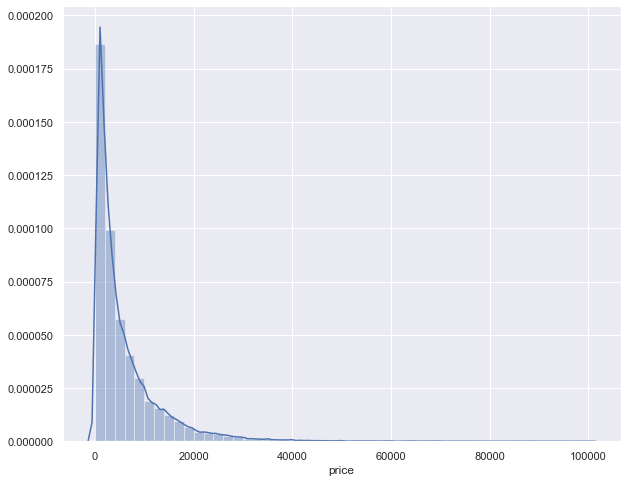

In [383]:
y = data['price']
plt.figure(figsize=(10,8))
sns.distplot(y)

In [384]:
# 相关性分析
print(data['power'].corr(data['price'], method='spearman'))
print(data['kilometer'].corr(data['price'], method='spearman'))
print(data['brand_amount'].corr(data['price'], method='spearman'))
print(data['brand_price_average'].corr(data['price'], method='spearman'))
print(data['brand_price_max'].corr(data['price'], method='spearman'))
print(data['brand_price_median'].corr(data['price'], method='spearman'))

0.5773425426332196
-0.4097783640876424
0.05438301230221679
0.38875954584355615
0.2587402623951201
0.39159165603497703


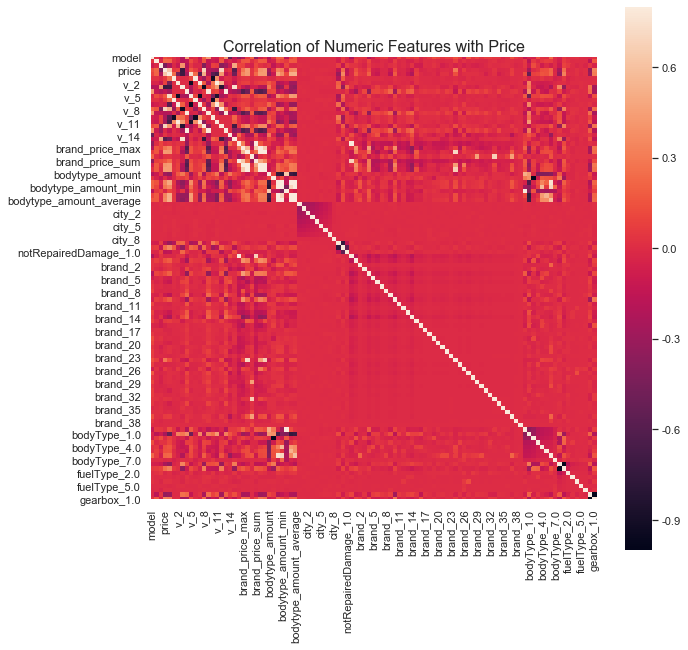

In [385]:
f , ax = plt.subplots(figsize = (10, 10))

plt.title('Correlation of Numeric Features with Price',y=1,size=16)
correlation = data.corr()
sns.heatmap(correlation,square = True,  vmax=0.8)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


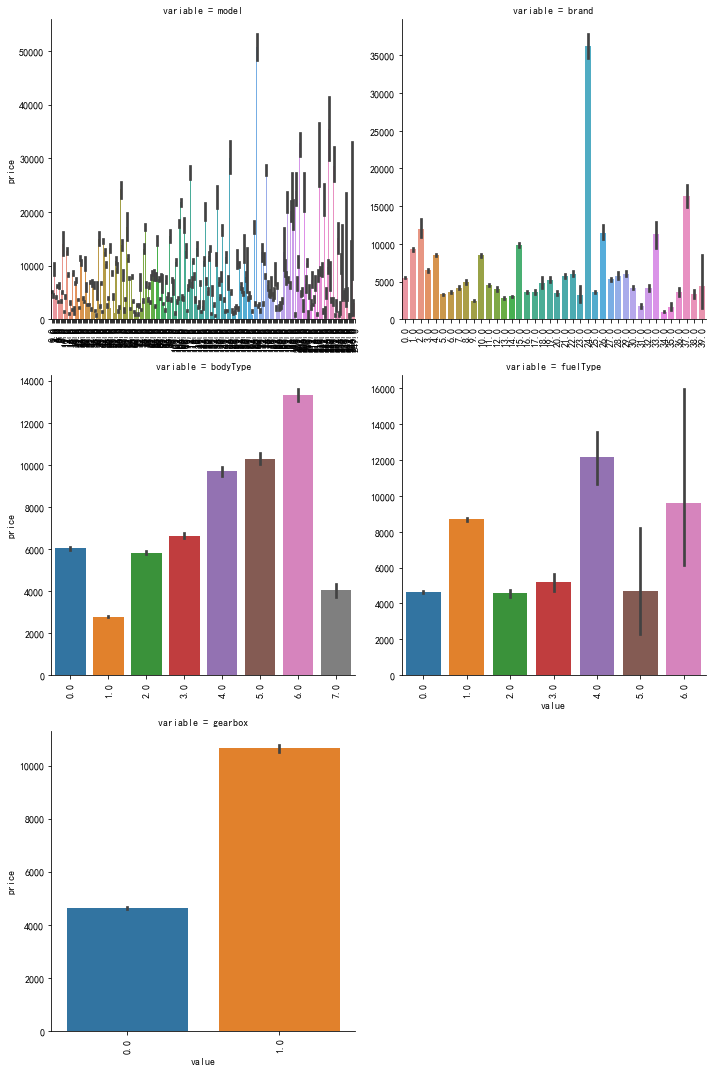

In [249]:
 ## 类别特征的柱形图可视化
categorical_features = ['model',
 'brand',
 'bodyType',
 'fuelType',
 'gearbox']

def bar_plot(x, y, **kwargs):
    sns.barplot(x=x, y=y)
    x=plt.xticks(rotation=90)

f = pd.melt(data, id_vars=['price'], value_vars=categorical_features)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(bar_plot, "value", "price")
plt.savefig('facegrid.png')

In [386]:
train_data = data[:train_data.shape[0]]
test_data = data[train_data.shape[0]:]

In [387]:
train_target = train_data['price']
del train_data['price']
test_target = test_data['price']
del test_data['price']

In [388]:
X_train,X_test,y_train,y_test = train_test_split(train_data, train_target) 

In [389]:
lr = LinearRegression()
lr.fit(X_train, y_train)
pred = lr.predict(X_test)
print('MAE loss:', mean_absolute_error(pred, y_test))

MAE loss: 2459.478331417037


In [391]:
dr = DecisionTreeRegressor()
dr.fit(train_data, train_target)
pred = dr.predict(test_data)
print('MAE loss:', mean_absolute_error(pred, test_target))

MAE loss: 905.6522111111111


In [267]:
pipeline_reg = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('reg', LinearRegression())
])
pipeline_reg.fit(train_data, train_target)
pred = pipeline_reg.predict(test_data)
print('MAE loss:', mean_absolute_error(pred, test_target))

MAE loss: 1444.0237190365533


In [208]:
pipeline_reg = Pipeline([
    ('scale', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('reg', LinearRegression())
])
pipeline_reg.fit(train_data, train_target)
pred = pipeline_reg.predict(test_data)
print('MAE loss:', mean_absolute_error(pred, test_target))

MAE loss: 1151.3723859375


In [392]:
gbr = GradientBoostingRegressor()
gbr.fit(train_data, train_target)
pred = gbr.predict(test_data)
print('MAE loss:', mean_absolute_error(pred, test_target))

MAE loss: 882.6128601234622


In [307]:
pipeline_reg = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', RandomForestRegressor())
])
pipeline_reg.fit(train_data, train_target)
pred = pipeline_reg.predict(test_data)
print('MAE loss:', mean_absolute_error(pred, test_target))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


MAE loss: 660.029680095238


In [361]:
rfr = RandomForestRegressor(max_depth=20, max_features=30)
rfr.fit(X_train, y_train)
pred = rfr.predict(X_test)
print('MAE loss:', mean_absolute_error(pred, y_test))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


MAE loss: 678.8583646044265


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

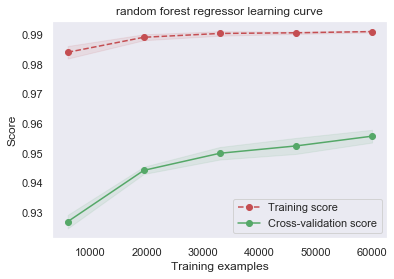

In [362]:
plot_learning_curve(plt, rfr, 'random forest regressor learning curve', X_train, y_train)

In [179]:
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
pred = rfr.predict(test_data)
print('MAE loss:', mean_absolute_error(pred, test_target))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


MAE loss: 677.7003975


In [182]:
params = {
    'n_estimators':np.linspace(7,13,7).astype(np.int8),
    'max_features': range(5,40),
    'max_depth': range(10,50)
}
grid_search = RandomizedSearchCV(RandomForestRegressor(), params, verbose=2)
%time grid_search.fit(X_train, y_train)
grid_search.score(X_test, y_test)
print(grid_search.best_params_, grid_search.best_score_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=9, max_features=37, max_depth=22 ...................
[CV] .... n_estimators=9, max_features=37, max_depth=22, total=   9.5s
[CV] n_estimators=9, max_features=37, max_depth=22 ...................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.4s remaining:    0.0s


[CV] .... n_estimators=9, max_features=37, max_depth=22, total=   9.6s
[CV] n_estimators=9, max_features=37, max_depth=22 ...................
[CV] .... n_estimators=9, max_features=37, max_depth=22, total=   9.5s
[CV] n_estimators=8, max_features=19, max_depth=32 ...................
[CV] .... n_estimators=8, max_features=19, max_depth=32, total=   4.7s
[CV] n_estimators=8, max_features=19, max_depth=32 ...................
[CV] .... n_estimators=8, max_features=19, max_depth=32, total=   4.7s
[CV] n_estimators=8, max_features=19, max_depth=32 ...................
[CV] .... n_estimators=8, max_features=19, max_depth=32, total=   4.7s
[CV] n_estimators=7, max_features=24, max_depth=46 ...................
[CV] .... n_estimators=7, max_features=24, max_depth=46, total=   5.1s
[CV] n_estimators=7, max_features=24, max_depth=46 ...................
[CV] .... n_estimators=7, max_features=24, max_depth=46, total=   5.0s
[CV] n_estimators=7, max_features=24, max_depth=46 ...................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  3.5min finished


Wall time: 3min 48s
{'n_estimators': 12, 'max_features': 31, 'max_depth': 42} 0.955537634294886


In [202]:
final_rfr = RandomForestRegressor(n_estimators=12, max_features=31, max_depth=42)
final_rfr.fit(train_data, train_target)
y_pred = final_rfr.predict(test_data)
print('MAE loss:', mean_absolute_error(y_pred, test_target))

MAE loss: 643.1223309926146


In [394]:
gbm = LGBMRegressor(objective='regression', num_leaves=31, learning_rate=0.05, n_estimators=20)
gbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='l1', early_stopping_rounds=5)

# 模型预测
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
print('MAE loss:', mean_absolute_error(y_pred, y_test))

[1]	valid_0's l1: 4814.13	valid_0's l2: 5.26781e+07
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l1: 4593.47	valid_0's l2: 4.81208e+07
[3]	valid_0's l1: 4385.86	valid_0's l2: 4.39977e+07
[4]	valid_0's l1: 4187.95	valid_0's l2: 4.02565e+07
[5]	valid_0's l1: 4002.76	valid_0's l2: 3.6919e+07
[6]	valid_0's l1: 3826.65	valid_0's l2: 3.38817e+07
[7]	valid_0's l1: 3659.88	valid_0's l2: 3.11257e+07
[8]	valid_0's l1: 3501.74	valid_0's l2: 2.86294e+07
[9]	valid_0's l1: 3351.98	valid_0's l2: 2.63687e+07
[10]	valid_0's l1: 3209.6	valid_0's l2: 2.43153e+07
[11]	valid_0's l1: 3074.99	valid_0's l2: 2.24315e+07
[12]	valid_0's l1: 2947.42	valid_0's l2: 2.07221e+07
[13]	valid_0's l1: 2826.87	valid_0's l2: 1.91904e+07
[14]	valid_0's l1: 2713.04	valid_0's l2: 1.7781e+07
[15]	valid_0's l1: 2605.55	valid_0's l2: 1.65119e+07
[16]	valid_0's l1: 2503.48	valid_0's l2: 1.53522e+07
[17]	valid_0's l1: 2407.52	valid_0's l2: 1.4284e+07
[18]	valid_0's l1: 2317.79	valid_0's l2: 1.33298e+07

In [157]:
estimator = LGBMRegressor(num_leaves=31)
param_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [20, 40]
}
gbm = GridSearchCV(estimator, param_grid)
gbm.fit(X_train, y_train)
print('Best parameters found by grid search are:', gbm.best_params_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best parameters found by grid search are: {'learning_rate': 0.1, 'n_estimators': 40}


In [210]:
estimator = LGBMRegressor(num_leaves=31, learning_rate=0.1, n_estimators=40)
gbm.fit(train_data, train_target)
pred = gbm.predict(test_data)
print('MAE loss:', mean_absolute_error(pred, test_target))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


MAE loss: 811.4319206140007


模型融合

In [395]:
def Weighted_method(test_pre1,test_pre2,test_pre3,w=[1/3,1/3,1/3]):
    Weighted_result = w[0]*pd.Series(test_pre1)+w[1]*pd.Series(test_pre2)+w[2]*pd.Series(test_pre3)
    return Weighted_result

## Init the Weight
w = [0.3,0.4,0.3]
val_lgb = gbm.predict(train_data) #811
val_rfr = dr.predict(train_data) #643
val_gbdt = gbr.predict(train_data) #875
## 测试验证集准确度
val_pre = Weighted_method(val_lgb,val_rfr,val_gbdt,w)
MAE_Weighted = mean_absolute_error(train_target,val_pre)
print('MAE of Weighted of val:',MAE_Weighted)

MAE of Weighted of val: 798.5814015191462


In [396]:
## Init the Weight
w = [0.3,0.4,0.3]
val_lgb = gbm.predict(test_data)
val_rfr = dr.predict(test_data)
val_gbdt = gbr.predict(test_data)
## 测试验证集准确度
val_pre = Weighted_method(val_lgb,val_rfr,val_gbdt,w)
MAE_Weighted = mean_absolute_error(test_target, val_pre)
print('MAE of Weighted of val:',MAE_Weighted)

MAE of Weighted of val: 1030.9451713923472


In [397]:
from sklearn.model_selection import StratifiedKFold
## 5折交叉验证方式
sk=StratifiedKFold(n_splits=5,shuffle=True,random_state=0)
scores_train, scores = [], []
for train_ind,val_ind in sk.split(train_data,train_target):
    
    train_x=train_data.iloc[train_ind].values
    train_y=train_target.iloc[train_ind]
    val_x=train_data.iloc[val_ind].values
    val_y=train_target.iloc[val_ind]
    
    rfr.fit(train_x,train_y)
    pred_train_xgb=rfr.predict(train_x)
    pred_xgb=rfr.predict(val_x)
    
    score_train = mean_absolute_error(train_y,pred_train_xgb)
    scores_train.append(score_train)
    score = mean_absolute_error(val_y,pred_xgb)
    scores.append(score)

print('Train mae:',np.mean(score_train))
print('Val mae',np.mean(scores))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Train mae: 322.0237130724284
Val mae 672.7532027332011
